# Simple wave sediment modelling

:::{note}
Using a wave propagation model based on linear wave theory, we investigate the cumulative effect of a given wave forcing condition on erosional and depositional trend across a regional coastal system.</div>
:::

Loading required modules for this exercise. The main module here is **wavesed** a piece of code that was developed for this course and that can be found on [GitHub](https://github.com/pyReef-model/wavesed)

In [1]:
!cd wavesed/; f2py -c -m ocean ocean.f90    

In [1]:
import time
import numpy as np
import wavesed.wave as ocean

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## <a name="setup"></a>  Model set-up


The model requires several parameters to be defined before being run. The most important one being the initial bathymetry. For this example, we will use the region around [Fraser Island](https://www.google.com.au/maps/@-24.8590806,152.2555941,236264m/data=!3m1!1e3?hl=en) at a resolution of 1000 m. The _digital elevation model_ (DEM) comes from the [Project 3DGBR](http://eatlas.org.au/data/uuid/200aba6b-6fb6-443e-b84b-86b0bbdb53ac).

```{eval-rst}
.. figure:: ../pracenv/figs/ex4-fig1.png
  :width: 60 %
  :alt: fraser
  :align: center
  
  Fraser Island from Google Earth.
```

The file is called **FraserDEM.csv** and is located in the **data** folder. It is made of 3 columns containing the X, Y, and Z coordinates. 

### Model domain / grid parameters

It is possible to change the initial resolution by using the `rfac` parameter, as an example:

+ `rfac = 1` corresponds to a model at 1000 m resolution (similar to the initial DEM)
+ `rfac = 2` transforms the dataset to 2000 m resolution 

In [2]:
# Bathymetric filename
bfile = '../pracenv/dataset/FraserDEM.csv'
# Resolution factor
rfac = 1 

### Definition of wave parameters

Now we need to define the forcing parameters for our simulation:

+ `H0` the deep water wave height in [m],
+ `dir` the deep water wave source direction at the boundary in degrees (angle is defined counterclock wise from horizontal axis)
+ `wbase` the maximum depth for wave influence on seabed [m]
+ `slvl` the sea-level position in [m]

In [3]:
# Wave height
H0 = 2
# Wave direction at boundary 
dir = 0
# Maximum depth for wave influence (m)
wbase = 10
# Sea level position (m)
slvl = 0.
# Output figure name
outname = 'wdir0'

### Definition of sediment parameters

To estimate wave-induced sediment transport, this simple model only accounts for a single grain size that needs to be defined (`d50`). 

There are also additional parameters that can be set to perform longshore and diffusive transport but we will use the default values for this example...

In [4]:
# Mean grain size diameter in m
d50 = 0.0001

## <a name="init"></a>  Model initialisation function

Now that all the parameters are defined in our python environment, we can initialise the simulation by calling the wavesed module:

In [5]:
#help(ocean.wave.__init__)

In [6]:
wavesed = ocean.wave(filename=bfile, wavebase=wbase, resfac=rfac, dia=d50)

As you can see from the command above there are still some parameters that have not been passed to the module:

+ `slvl`
+ `dir`
+ `H0`

These parameters are sent separately so that multiple climatic conditions could be simulate more easily.

First we define the sea-level position `slvl`.

In [7]:
t0 = time.clock()
wavesed.findland(slvl)
print('Definition of shoreline position took (s):',time.clock()-t0)

Definition of shoreline position took (s): 0.003338999999999981


Initialising wave boundary direction `dir` is then done with the `wavesource` function:

In [8]:
wdir = wavesed.wavesource(dir)

## <a name="evol"></a>  Waves evolution

The waves are then transformed using the **linear wave theory** from deep (set-up conditions) to shallow water assuming shore-parallel depth contours. 

The orientation of wave fronts is determined by wave _celerity_ and _refraction_ due to depth variations. 

Travel time in the domain is calculated from **Huygen's principle** (using an order $\sqrt{5}$ approximation).

Assuming no refraction or loss of energy due to bottom friction, wave power $P$ is conserved from deep to shallow water. 

In [9]:
#help(wavesed.cmptwaves)

In [10]:
t0 = time.clock()
wavesed.cmptwaves(src=wdir, h0=H0, sigma=1.)
print('Wave evolution computation took (s): ',time.clock()-t0)

Wave evolution computation took (s):  0.37950000000000017


### Plotting simulated wave characteristics

A series of graph can be visualised to show the following characteristics:

+ _bathy_: coarse bathymetric map
+ _wlength_: coarse wave lenght map
+ _travel_: coarse wave travel time map
+ _wcelerity_: coarse wave celerity map
+ _wheight_: coarse wave height map
+ _wpower_: coarse wave power map
+ _ubot_: coarse wave induced bottom velocity map
+ _shear_: coarse wave induced shear stress map

In [11]:
#help(wavesed.plotData)

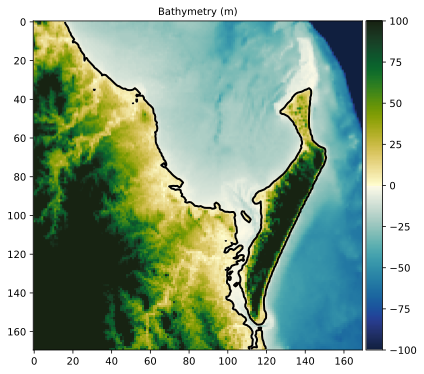

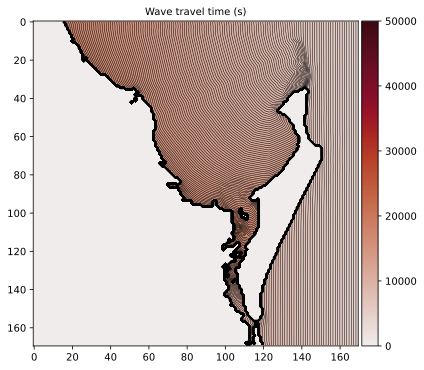

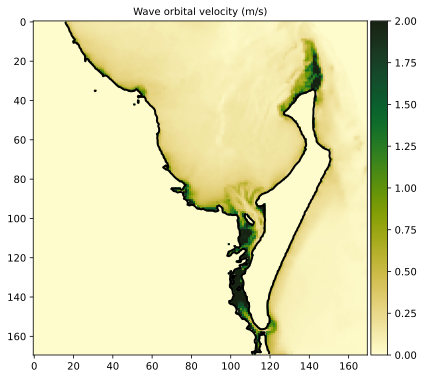

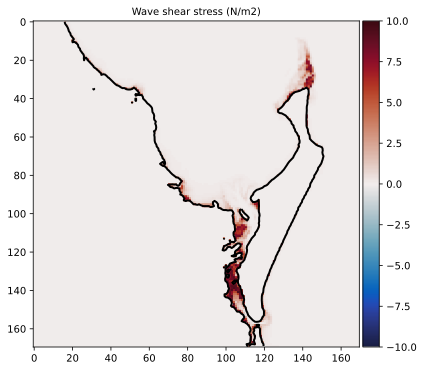

In [12]:
size = (6,6)
# i1 = 0 
# i2 = -1
# j1 = 0
# j2 = -1

# Zooming to a specific region
i1 = 80 
i2 = 250 
j1 = 0
j2 = 170 

wavesed.plotData(data='bathy', figsize=size, vmin=-100, vmax=100, 
                 fontsize=10, imin=i1, imax=i2, jmin=j1, jmax=j2)

wavesed.plotData(data='travel', figsize=size, tstep=100, vmin=0, vmax=5.e4, 
                 fontsize=10, imin=i1, imax=i2, jmin=j1, jmax=j2)

wavesed.plotData(data='wcelerity', figsize=size, vmin=0, vmax=15, 
                 fontsize=10, stream=3, imin=i1, imax=i2, jmin=j1, jmax=j2)

wavesed.plotData(data='ubot', figsize=size, vmin=0, vmax=2, 
                 fontsize=10, imin=i1, imax=i2, jmin=j1, jmax=j2)

wavesed.plotData(data='shear', figsize=size, vmin=-10, vmax=10, 
                  fontsize=10, imin=i1, imax=i2, jmin=j1, jmax=j2)

## <a name="sed"></a>  Sediment entrainment, transport & deposition

**Sediment entrainment** relates to wave induced shear stress. 

The transport is computed according to both wave direction and longshore transport. Deposition is dependent of shear stress and diffusion.

In [13]:
#help(wavesed.cmptsed)

In [14]:
t0 = time.clock()
wavesed.cmptsed(sigma=1.)
print('Sediment erosion/deposition computation took (s): ',time.clock()-t0)

Sediment erosion/deposition computation took (s):  0.396745000000001


### Plotting morphological changes

Using the same plotting function (`plotData`), we can now plot the following metrics:

+ _ent_: coarse sediment entrainment map
+ _dz_: coarse erosion/deposition map

In [15]:
#help(wavesed.plotData)

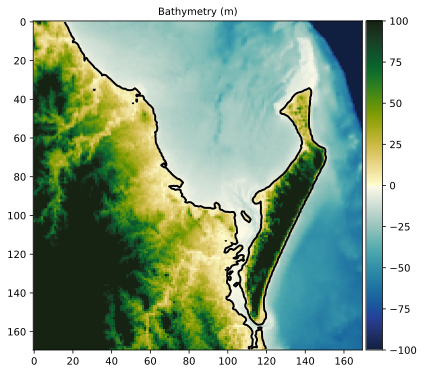

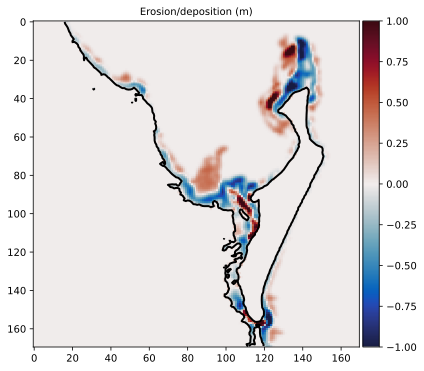

In [16]:
size = (6,6)
# i1 = 0 
# i2 = -1
# j1 = 0
# j2 = -1

# Zooming to a specific region
i1 = 80 
i2 = 250 
j1 = 0
j2 = 170

wavesed.plotData(data='bathy', figsize=size, vmin=-100, vmax=100, 
                 fontsize=10, stream=0, imin=i1, imax=i2, jmin=j1, jmax=j2)

wavesed.plotData(data='ent', figsize=size, vmin=0., vmax=5., 
                 fontsize=10, stream=0, imin=i1, imax=i2, jmin=j1, jmax=j2)

wavesed.plotData(data='dz', figsize=size, vmin=-1., vmax=1., 
                 fontsize=10, stream=0, imin=i1, imax=i2, jmin=j1, jmax=j2) #, save=outname)


## <a name="save"></a>  Saving wave/sedimentation data



In [ ]:
#waveparams.outputCSV(filename='erodep.csv', seddata=1)

***
:::{note}

1. Change the initial wave direction conditions to 90 and then to 270. Evaluate the impact on the morphological patterns. 
2. Change the resolution factor to see how it impacts on erosion/deposition resolution.</div>

:::
***